In [1]:
#pip install pmdarima

In [2]:
#import sys
#!{sys.executable} -m pip install pmdarima

In [7]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima.arima import auto_arima

In [4]:
df = pd.read_csv("DataSet/AirPassengers.csv",parse_dates=["Month"],index_col=["Month"])

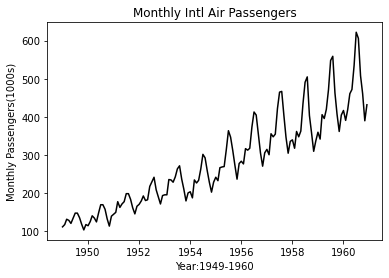

In [8]:
fig,ax = plt.subplots()
plt.xlabel("Year:1949-1960")
plt.ylabel("Monthly Passengers(1000s)")
plt.title("Monthly Intl Air Passengers")
plt.plot(df,color="black")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
#shows a upward trend with a sesonal trend

In [11]:
#training dataset range 1949-1957
#testing dataset range 1958-1960
trn = df.loc[df.index <"1958-01-01"]
tst = df.loc[df.index >="1958-01-01"]

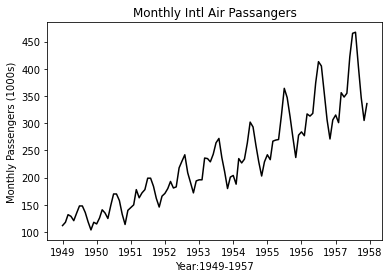

In [12]:
#training data plotiing 
fig, ax = plt.subplots()
plt.xlabel("Year:1949-1957")
plt.ylabel("Monthly Passengers (1000s)")
plt.title("Monthly Intl Air Passangers")
plt.plot(trn,color="black")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))

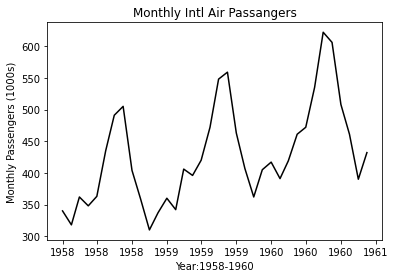

In [13]:
#training data plotiing 
fig, ax = plt.subplots()
plt.xlabel("Year:1958-1960")
plt.ylabel("Monthly Passengers (1000s)")
plt.title("Monthly Intl Air Passangers")
plt.plot(tst,color="black")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))

### Testing stationarity

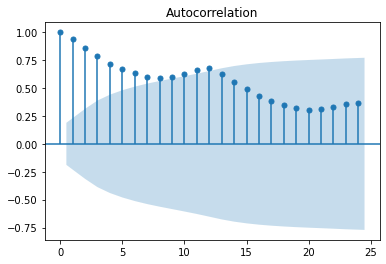

In [14]:
#ARIMA needs non-stationary data
#non-stationary means - data where mean,variance and(/or) covariance vary overtime
#non_stationary data shows a significant correlations when lagged
#correlogram(plot_acf) will provide a degrre of correlation at different values of lags
trn_acf = plot_acf(trn,lags=24)

### Linear model

In [20]:
#linear regression model will act as a basline 
#dependant variable will be passengers while  independant varibale is a linear time trend,including a constant
lr= sm.OLS(endog=trn["#Passengers"],exog=sm.add_constant(np.arange(1,1+trn.shape[0]))).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:            #Passengers   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     526.7
Date:                Wed, 28 Jul 2021   Prob (F-statistic):           6.40e-43
Time:                        13:27:29   Log-Likelihood:                -536.80
No. Observations:                 108   AIC:                             1078.
Df Residuals:                     106   BIC:                             1083.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         95.0422      6.820     13.936      0.0

In [21]:
#extracting the fitted values
y_hat = lr.fittedvalues

In [22]:
#extract 95% prediction interval
y_ci = lr.get_prediction().conf_int(alpha=0.05)

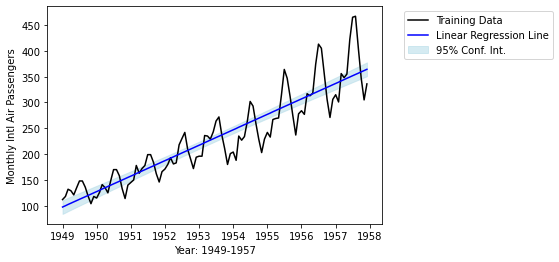

In [24]:
fig,ax = plt.subplots()
plt.xlabel("Year: 1949-1957")
plt.ylabel("Monthly Intl Air Passengers")
plt.plot(trn,color="black",label="Training Data")
plt.plot(y_hat,color ="blue",label="Linear Regression Line")
plt.fill_between(y_hat.index,y_ci[:,0],y_ci[:,1],color="lightblue",alpha=0.5,label="95% Conf. Int.")
9plt.legend(bbox_to_anchor=(1.05,1))
ax.xaxis.set_major_formatter(DateFormatter("%Y"))


In [35]:
#uing auto_arima function to find the best arima ,and assingin m =12(default m is 1) because of the 12 months
#We are conducting variations on ARIMA called "SARIMAX"
#SARIMAX -  Seasonal Auto Regressive Intergrated Moving Average with Exogenous Factors
auto_arima_model = auto_arima(trn,m=12, with_intercept= False,suppress_warnings=True)
print(auto_arima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -350.001
Date:                            Wed, 28 Jul 2021   AIC                            704.001
Time:                                    14:10:47   BIC                            709.109
Sample:                                         0   HQIC                           706.065
                                            - 108                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2411      0.091     -2.648      0.008      -0.420      -0.063
sigma2        92.7499     13.439   

auto_arima function suggest that ARIMA(1,1,0)(0,1,0,12)

Initial set of no[(1,1,0)] is for the basic: non-seasonal model

    1 #p : Autoregressive (AR) model
    1 #d : Integrated(I), or degree of differenciating
    0 #q : Moving average (MA) order
    
    
Second set of no[(0,1,0,12)] is for the seasonality 

    0  #P: Autoregressive (AR) model
    1  #D: Integrated(I), or degree of differenciating
    0  #Q: Moving average (MA) order
    12 #M: Model Period or Seasonality
   
    

In [26]:
auto_arima_model.order

(1, 1, 0)

In [34]:
auto_arima_model.seasonal_order

(0, 1, 0, 12)

Extracting the resudual and ploting them

In [32]:
resid = auto_arima_model.resid

AxisError: axis 0 is out of bounds for array of dimension 0

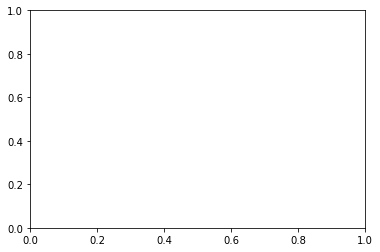

In [33]:
fig, ax = plt.subplots()
plt.plot(trn.index, stats.zscore(resid),color="gray")
plt.title("Standardized Residuals")
plt.xlabel("Year: 1949-1957")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))